# Import Libraries

In [1]:
import pandas as pd
import os
import time
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

print(tf.__version__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import *
import pandas as pd
import cv2
import math

import tensorflow as tf
from tensorflow.keras.layers import Dense
import keras
import keras.backend as K
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import Callback, ReduceLROnPlateau, ModelCheckpoint
from keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, Concatenate, Lambda, Layer
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, RandomRotation,Reshape
from tensorflow.keras.applications import DenseNet121
# Imports
import seaborn as sns
import random
from tqdm import tqdm

%matplotlib inline

2024-10-27 08:23:03.963026: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-27 08:23:03.963116: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-27 08:23:04.112070: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.15.0


# Data Generator List Class
Custom TensorFlow data generator for loading, augmenting, and batching grayscale images with optional labels for training, validation, and testing.

In [2]:
class DataGeneratorList(tf.keras.utils.Sequence):
    def __init__(self, ListPath: list, ListLabel = None, 
                 batch_size: int=16, mode = 'Train', shuffle=True):
        
        self.path = ListPath
        self.indices = np.arange(len(self.path))
        
        self.batch_size = batch_size
        self.mode = mode

        self.shuffle = shuffle
        
        if self.mode in ['Train', 'Val']:
            self.labels = ListLabel
        
        if self.shuffle:
            np.random.shuffle(self.indices)
    
    def __len__(self):
        return math.ceil(len(self.path) / self.batch_size)
    
    def __getitem__(self, index):
        batch_indices     = self.indices[index * self.batch_size: (index + 1) * self.batch_size]   
        batch_images_path = self.path[index * self.batch_size : (index + 1) * self.batch_size]
        
        batch_images = np.zeros((self.batch_size, 90, 90, 1))
        batch_labels_numpy = np.zeros((self.batch_size, 2))
        
        if self.mode == 'Train' :
            batch_labels = self.labels[index * self.batch_size : (index + 1) * self.batch_size]
            
            for idx, idx_rand in enumerate(batch_indices) :
                img_name = batch_images_path[list(batch_indices).index(idx_rand)]

                img  = cv2.imread(img_name) 
                img  = np.array(RandomRotation(0.2)(img))
                img  = cv2.resize(img, (90, 90))
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                gray = gray[:, :, None]
                    
                batch_images[idx, :, :, :] += gray
               
                batch_labels_numpy[idx, :] += np.array(batch_labels[list(batch_indices).index(idx_rand)])
               
            return np.float32(batch_images/255.0), np.float32(batch_labels_numpy)
        
        if self.mode == 'Val' :
            batch_labels = self.labels[index * self.batch_size : (index + 1) * self.batch_size]
            
            for idx, idx_rand in enumerate(batch_indices) :
                img_name = batch_images_path[list(batch_indices).index(idx_rand)]

                img  = cv2.imread(img_name) 
                img  = cv2.resize(img, (90, 90))
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                gray = gray[:, :, None]
                    
                batch_images[idx, :, :, :] += gray
               
                batch_labels_numpy[idx, :] += np.array(batch_labels[list(batch_indices).index(idx_rand)])
               
            return np.float32(batch_images/255.0), np.float32(batch_labels_numpy)
        
        if self.mode == 'Test' :
            for idx, idx_rand in enumerate(batch_indices) :
                img_name = batch_images_path[list(batch_indices).index(idx_rand)]
                
                img  = cv2.imread(img_name) 
                img  = cv2.resize(img, (90, 90))
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                gray = gray[:, :, None]

                batch_images[idx, :, :, :] += gray

            return np.float32(batch_images/255.0)

# Data Preparation

In [3]:
df_normal_data     = pd.read_csv('/kaggle/input/mliscar2/training_norm.csv')
df_collected_data1 = pd.read_csv("/kaggle/input/cleaned-data1/IMAGES/images.csv")
df_test            = pd.read_csv('/kaggle/input/mliscar2/sampleSubmission.csv')

len(os.listdir('/kaggle/input/mliscar2/training_data/training_data'))

Path_Train = []
Path_Test  = []
Label    = df_normal_data[['angle', 'speed']].values.tolist() 

for idx, path in enumerate(df_normal_data['image_id'].tolist()) :
    Path_Train.append('/kaggle/input/mliscar2/training_data/training_data/' + str(df_normal_data['image_id'].tolist()[idx]) + '.png')

for idx, path in enumerate(os.listdir("/kaggle/input/cleaned-data1/IMAGES/IMAGES")) :
    Path_Train.append('/kaggle/input/cleaned-data1/IMAGES/IMAGES/' + path)
    
for idx, path in enumerate(os.listdir("/kaggle/input/cleaned-data2/IMAGES_2")) :
    Path_Train.append('/kaggle/input/cleaned-data2/IMAGES_2/' + path)
    
for idx, path in enumerate(os.listdir("/kaggle/input/cleaned-data3/IMAGES_3")) :
    Path_Train.append('/kaggle/input/cleaned-data3/IMAGES_3/' + path)
    
# for idx, path in enumerate(os.listdir("/kaggle/input/t-junction/T_junction_cleaned")) :
#     Path_Train.append('/kaggle/input/t-junction/T_junction_cleaned/' + path)
    
for path in os.listdir("/kaggle/input/cleaned-data1/IMAGES/IMAGES"):
    Label.append([(int(path.split("_")[1])-50)/80, int(path.split("_")[2].split(".")[0])/35])

for path in os.listdir("/kaggle/input/cleaned-data2/IMAGES_2"):
    Label.append([(int(path.split("_")[1])-50)/80, int(path.split("_")[2].split(".")[0])/35])
    
for path in os.listdir("/kaggle/input/cleaned-data3/IMAGES_3"):
    Label.append([(int(path.split("_")[1])-50)/80, int(path.split("_")[2].split(".")[0])/35])
    
# for path in os.listdir("/kaggle/input/t-junction/T_junction_cleaned"):
#     Label.append([(int(path.split("_")[1])-50)/80, int(path.split("_")[2].split(".")[0])/35])

for idx, path in enumerate(df_test['image_id'].tolist()) :
    Path_Test.append('/kaggle/input/mliscar2/test_data/test_data/' + str(df_test['image_id'].tolist()[idx]) + '.png')

# Splitting Data and Initializing Data Generators

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(Path_Train, Label, 
                                                  test_size=0.1, random_state=1)

train_generator = DataGeneratorList(X_train, y_train, batch_size = 128, 
                                mode = 'Train', shuffle=True)
valid_generator = DataGeneratorList(X_val, y_val, batch_size = 128, 
                               mode = 'Val', shuffle=False)

# Custom Loss Function

Combines Mean Squared Error (MSE) and Binary Cross-Entropy (BCE) to handle both regression and classification components in a model's output. It calculates separate losses for each component, then returns their combined value for optimization.

In [5]:
class ModifiedBCELoss(tf.keras.losses.Loss):
    def _init_(self, weight_factor=1.0, reduction=tf.keras.losses.Reduction.AUTO, 
               name='modified_BCE_loss'):
        super(ModifiedBCELoss, self)._init_(reduction=reduction, name=name)
        self.weight_factor = weight_factor

    def call(self, out, y_true):
        MSE_A, probB = tf.transpose(out)[0], tf.transpose(out)[1]

        y_trueT = tf.transpose(y_true)
        
        Atrue, Btrue = y_trueT[0], y_trueT[1]
        
        MSE = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
        bce = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE, 
                                                 from_logits=False)
    
        LossA = tf.reduce_mean(MSE(MSE_A, Atrue))
        LossB = tf.reduce_mean(bce(probB, Btrue))
        
        return (LossA + LossB)    

# Squeeze and excitation block
SEBlock module enhances feature extraction by applying global average pooling and channel-wise scaling, allowing the model to prioritize relevant features. Through a combination of dense layers with ReLU and sigmoid activations, it dynamically adjusts the importance of each channel, refining the model’s focus for improved accuracy.

In [6]:
class SEBlock(Layer):
    def __init__(self, ratio=16):
        super(SEBlock, self).__init__()
        self.ratio = ratio

    def build(self, input_shape):
        self.fc1 = Dense(input_shape[-1] // self.ratio, activation='relu')
        self.fc2 = Dense(input_shape[-1], activation='sigmoid')

    def call(self, inputs):
        # Squeeze: Global average pooling
        squeeze = GlobalAveragePooling2D()(inputs)
        
        # Excitation
        squeeze = Reshape((1, 1, -1))(squeeze)
        excitation = self.fc1(squeeze)
        excitation = self.fc2(excitation)
        
        # Scale
        scale = inputs * excitation
        return scale , excitation

# Model Architecture
This model fine-tunes DenseNet121's last 127 layers, adds SE blocks for feature emphasis, and outputs both regression and classification results.

In [7]:
densenet_model = DenseNet121(include_top=False, input_shape=(90, 90, 3))
for layer in densenet_model.layers[:-127]:  # Freeze all layers except the last 127 layers
    layer.trainable = False

input_layer = Input(shape=(90, 90, 1))
x = Conv2D(filters=3, kernel_size=1, strides=1, activation='relu', name="Conv1")(input_layer)
x = densenet_model(x)
x = Conv2D(filters=512, kernel_size=(2,2), strides=1, activation='relu', name="Conv2")(x)
x, excitation = SEBlock()(x)
x = Flatten()(x)
x = Dense(256, activation='relu', name='Dense1')(x)

x_reg = Dense(1, name='regression_output')(x)
x_sig = Dense(1, activation='sigmoid', name='classification_output')(x)

model = Model(inputs= input_layer, outputs=[tf.concat((x_reg, x_sig), 1)])

model.summary()

29084464/29084464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 90, 90, 1)]          0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 90, 90, 3)            6         ['input_2[0][0]']             
                                                                                                  
 densenet121 (Functional)    (None, 2, 2, 1024)           7037504   ['Conv1[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 1, 1, 512)            2097664   ['densenet121[0][0]']         
                             

In [8]:
custom_loss = ModifiedBCELoss()

Train the model with early stopping and adaptive learning rate adjustments based on validation loss, saving the best weights for optimal performance. The ModelCheckpoint callback ensures only the best model is saved by monitoring val_loss.

In [19]:
Checkpoint = ModelCheckpoint('/kaggle/working/Densenet_new_100_att_rt.h5', 
                             save_best_only=True,
                             monitor='val_loss', 
                             verbose=1, save_weights_only=True)

model.compile(loss=custom_loss, optimizer=Adam(1e-3))

### Train the model on all available devices.
model.fit(train_generator, 
          validation_data = valid_generator, 
          epochs    = 15,
          callbacks = [ReduceLROnPlateau(monitor='val_loss', factor=0.6, mode='min',
                                       patience=4, min_lr=0.00001), 
                       EarlyStopping(monitor='val_loss', patience=7, mode='min',
                                     restore_best_weights = True), 
                       Checkpoint] )

Epoch 1/15
125/125 [==============================] - ETA: 0s - loss: 0.1853
Epoch 1: val_loss improved from inf to 0.26107, saving model to /kaggle/working/Densenet_new_100_att_rt.h5
125/125 [==============================] - 290s 2s/step - loss: 0.1853 - val_loss: 0.2611 - lr: 0.0010
Epoch 2/15
125/125 [==============================] - ETA: 0s - loss: 0.1075
Epoch 2: val_loss improved from 0.26107 to 0.14694, saving model to /kaggle/working/Densenet_new_100_att_rt.h5
125/125 [==============================] - 268s 2s/step - loss: 0.1075 - val_loss: 0.1469 - lr: 0.0010
Epoch 3/15
125/125 [==============================] - ETA: 0s - loss: 0.0940
Epoch 3: val_loss improved from 0.14694 to 0.08811, saving model to /kaggle/working/Densenet_new_100_att_rt.h5
125/125 [==============================] - 273s 2s/step - loss: 0.0940 - val_loss: 0.0881 - lr: 0.0010
Epoch 4/15
125/125 [==============================] - ETA: 0s - loss: 0.0874
Epoch 4: val_loss improved from 0.08811 to 0.08117, sa

In [22]:
model.load_weights('/kaggle/working/Densenet_new_100_att_rt.h5')

# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('Densenet_new_100_att_rt.tflite', 'wb') as f:
    f.write(tflite_model)

Summary on the non-converted ops:
---------------------------------
 * Accepted dialects: tfl, builtin, func
 * Non-Converted Ops: 333, Total Ops 682, % non-converted = 48.83 %
 * 333 ARITH ops

- arith.constant:  333 occurrences  (f32: 321, i32: 12)



  (f32: 64)
  (f32: 3)
  (f32: 59, i32: 2)
  (f32: 122)
  (f32: 5)
  (i32: 4)
  (f32: 2)
  (f32: 1)
  (f32: 1)
  (f32: 63)

  (i32: 3)
  (f32: 2)
  (i32: 4)
  (f32: 6)
  (i32: 3)
  (i32: 1)


Image shape for model input: (1, 90, 90, 1)


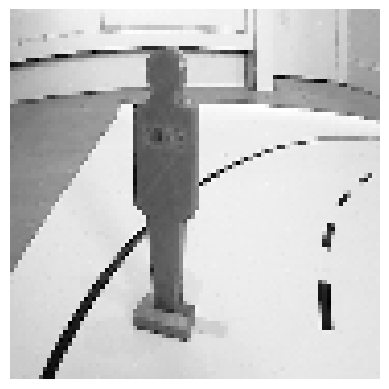

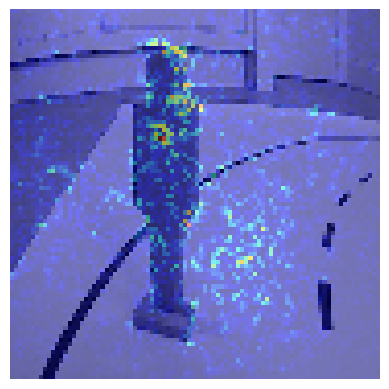

In [32]:
def prepare_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
    img = cv2.resize(img, (90, 90))
    img = img / 255.0  # Normalize to [0, 1]
    
    # Add the channel dimension to make it (90, 90, 1)
    img_grayscale = np.expand_dims(img, axis=-1)  # Shape: (90, 90, 1)
    
    # Add a batch dimension to make it (1, 90, 90, 1)
    img_grayscale = np.expand_dims(img_grayscale, axis=0)
    
    return img_grayscale, img

img_path = '/kaggle/input/mliscar2/test_data/test_data/35.png'
image, image_display = prepare_image(img_path)
print("Image shape for model input:", image.shape)

# Display the image
plt.imshow(image_display, cmap='gray')
plt.axis('off')
plt.show()


def compute_saliency_map(model, input_image):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        predictions = model(input_image)
        loss = tf.reduce_max(predictions)  # Maximize the response
    
    # Compute the gradient of the loss with respect to the input
    gradient = tape.gradient(loss, input_image)
    gradient = tf.abs(gradient)
    gradient = tf.reduce_max(gradient, axis=-1)
    return gradient[0]  # Remove batch dimension

# Prepare image for the model
img_rgb, img_display = prepare_image(img_path)

# Compute saliency map
saliency_map = compute_saliency_map(model, tf.convert_to_tensor(img_rgb))

# Plotting the result
plt.imshow(img_display, cmap='gray')
plt.imshow(saliency_map, cmap='jet', alpha=0.5)  # Overlay with transparency
plt.axis('off')
plt.show()